# Fun applications

In [34]:
import pandas as pd 
import pandas_datareader
import datetime
import matplotlib.pyplot as plt

# Friday effect in the stock market? 

Let's investigate if there is a "Friday effect" on the stock market. That is, do stock prices on average increase more on Fridays than they do on other days of the week? 

**Reading in data**

In [35]:
start = datetime.datetime(2014,1,1)
end   = datetime.datetime(2018,1,1)

In [36]:
firms = [] 
for i,stock_name in enumerate(['IBM','AAPL', 'TSLA']): 
    firm_stock = pandas_datareader.iex.daily.IEXDailyReader(stock_name, start, end).read()
    firm_stock['firm'] = stock_name
    firms.append(firm_stock)

In [37]:
stocks = pd.concat(firms)

In [38]:
stocks.sample(3)

,open,high,low,close,volume,firm
date,,,,,,
2015-09-08,104.9996,105.8554,103.7488,105.6203,54843626,AAPL
2017-08-03,345.3300,350.0000,343.1500,347.0900,13535033,TSLA
2015-08-10,109.5889,112.8428,109.5889,112.5889,54951597,AAPL


In [39]:
# convert index from type 'O' to 'datetime' 
stocks.index = pd.to_datetime(stocks.index)

In [40]:
# sort dataframe
stocks.sort_values(['firm','date'], inplace=True)

In [41]:
# 1. create the weekday variable 
stocks['weekday'] = stocks.index.weekday
stocks['year']    = stocks.index.year

**First differences:** Here we must avoid the temptation to use `df.var.diff(1)`, which will take differences across different firms. Instead, we have to use `df.groupby('firm').var.diff(1)` to ensure that we stay within the firm. This will produce a NaN as the first value for each firm. 

In [42]:
stocks['diff_close'] = stocks.groupby('firm').close.diff(1)

## Analysis based on raw averages

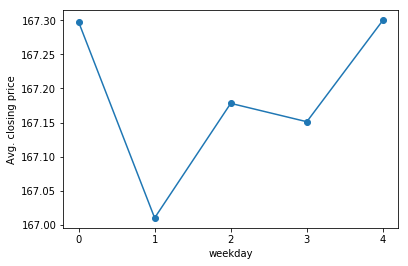

In [43]:
ax = stocks.groupby('weekday')['close'].mean().plot(kind='line', style='-o'); 
ax.set_ylabel('Avg. closing price'); 
ax.set_xticks(range(5)); 

**Mean** 

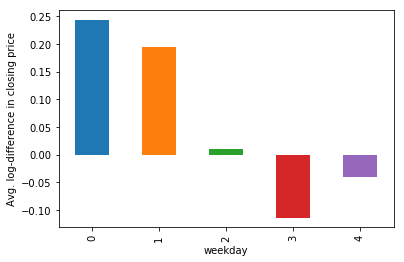

In [44]:
ax = stocks.groupby('weekday')['diff_close'].mean().plot(kind='bar'); 
ax.set_ylabel('Avg. log-difference in closing price'); 

**Median**

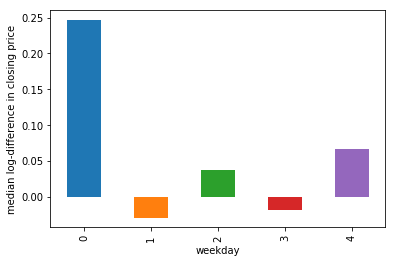

In [45]:
# could there be outliers? then the median is better than the mean 
ax = stocks.groupby('weekday')['diff_close'].median().plot(kind='bar'); 
ax.set_ylabel('median log-difference in closing price'); 

**By firm** 

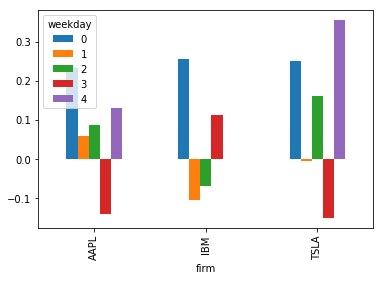

In [46]:
# effects by firms? 
stocks.groupby(['firm','weekday']).diff_close.median().unstack().plot(kind='bar'); 

**Summing up so far:** It seems that companies iffer, but there is a tendency to higher prices on Mondays... surprisingly (maybe we'd expect people to be angry and pessimistic Monday morning?)

**Question:** What about quantities? If they differ over the week, it's not so surprising that prices differ as well. 

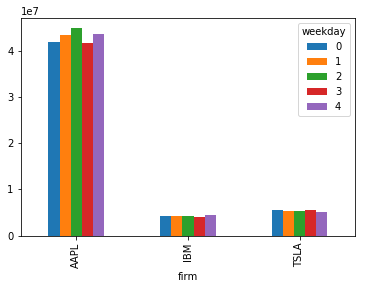

In [47]:
# Avg. quantity by day by firm
stocks.groupby(['firm','weekday']).volume.mean().unstack().plot(kind='bar'); 

Damn, Apple's volume is so much higher, we cannot compare these directly. We can't even look at deviations from the mean, since even those are larger. However, *percent deviations from the mean* might make sense. 

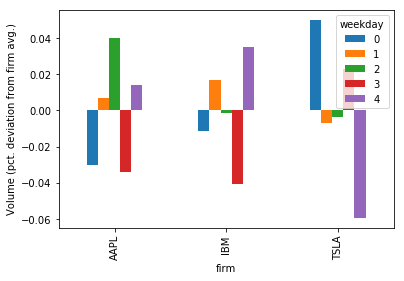

In [48]:
# transformation frunction 
def pct_deviation_from_mean(x): 
    m = np.mean(x)
    dev = (x-m)/m
    return dev

# one-step split-apply-combine
stocks['vol_pct_dev_from_mean'] = stocks.groupby('firm')['volume'].transform(pct_deviation_from_mean)

# plot
ax = stocks.groupby(['firm','weekday'])['vol_pct_dev_from_mean'].mean().unstack().plot(kind='bar'); 
ax.set_ylabel('Volume (pct. deviation from firm avg.)'); 

## Analysis based on regressions

Let's run the regression 
\\[ \Delta p_{jt} = \beta_0 + \text{weekday dummies} + \text{firm fixed effect} + \text{year fixed effects} + \text{error} \\]

The weekday fixed effects will be so that 0 = Monday (left out, the reference category), 1 = Tuesday, ..., 4 = Friday. Thus, we test for the Friday effect by examining the p-value for the 4th weekday, denoted `C(weekday)[T.4]`. 

***Note*** We will not expect regressions in any of your work. 

In [49]:
import statsmodels.formula.api as sm
res = sm.ols(formula = 'diff_close~C(weekday)+C(firm)+C(year)', data = stocks).fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             diff_close   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.6439
Date:                Tue, 19 Mar 2019   Prob (F-statistic):              0.760
Time:                        09:01:10   Log-Likelihood:                -7809.3
No. Observations:                2862   AIC:                         1.564e+04
Df Residuals:                    2852   BIC:                         1.570e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.2316      0.230      1.005      0.315      -0.220       0.684
C(weekday)[T.1]    -0.0490      0.222     -0.221      0.825      -0.483       0.385
C(weekday)[T.2]    -0.2353      0.221     -1.064      0.288      -0.669       0.199
C(weekday)[T.3]    -0.3590      0.223     -1.612      0.107      -0.796       0.078
C(weekday)[T.4]    -0.2862      0.223     -1.282      0.200      -0.724       0.152
C(firm)[T.IBM]     -0.1102      0.170     -0.649      0.517      -0.443       0.223
C(firm)[T.TSLA]    -0.0217      0.170     -0.128      0.898      -0.355       0.311
C(year)[T.2015]    -0.0021      0.203     -0.010      0.992      -0.401       0.396
C(year)[T.2016]     0.0234      0.203      0.115      0.908      -0.375       0.422
C(year)[T.2017]     0.1958      0.203      0.963      0.336      -0.203       0.595
==============================================================================
Omnibus:                      551.229   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9101.672
Skew:                          -0.431   Prob(JB):                         0.00
Kurtosis:                      11.694   Cond. No.                         7.30
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Want $\LaTeX$? No problem! 

In [50]:
res.summary().as_latex()

'\\begin{center}\n\\begin{tabular}{lclc}\n\\toprule\n\\textbf{Dep. Variable:}    &    diff_close    & \\textbf{  R-squared:         } &     0.002   \\\\\n\\textbf{Model:}            &       OLS        & \\textbf{  Adj. R-squared:    } &    -0.001   \\\\\n\\textbf{Method:}           &  Least Squares   & \\textbf{  F-statistic:       } &    0.6439   \\\\\n\\textbf{Date:}             & Tue, 19 Mar 2019 & \\textbf{  Prob (F-statistic):} &    0.760    \\\\\n\\textbf{Time:}             &     09:01:10     & \\textbf{  Log-Likelihood:    } &   -7809.3   \\\\\n\\textbf{No. Observations:} &        2862      & \\textbf{  AIC:               } & 1.564e+04   \\\\\n\\textbf{Df Residuals:}     &        2852      & \\textbf{  BIC:               } & 1.570e+04   \\\\\n\\textbf{Df Model:}         &           9      & \\textbf{                     } &             \\\\\n\\bottomrule\n\\end{tabular}\n\\begin{tabular}{lcccccc}\n                         & \\textbf{coef} & \\textbf{std err} & \\textbf{t} & \\te

**Conclusion:** The Friday dummy is not statistically significantly different from zero (p = 0.087 > 0.05). Thus, we conclude that there is no more growth in prices on Fridays compared to other days. 

# The relationship between income and CO2 emissions

What is the relationship between GDP and emissions? Do the rich pollute more than the poor? Do fast-growing countries start polluting more? 

## Downloading data

We will use the World Bank as the source of our data. See more here: https://data.worldbank.org/indicator/EN.ATM.CO2E.PC?locations=US-CN-DK-RU&view=chart

In [51]:
from pandas_datareader import wb

In [52]:
countries = ['DK','ZA','US','GB','CN','IN','BR','CA','RU','KR','VN','SE','DE','FR','BG','IT','PK','ID','MX','PL']

In [53]:
co2 = wb.download(indicator='EN.ATM.CO2E.KT', country=countries, start=1970, end=2017) # alternatively, "EN.ATM.CO2E.PC" is per cap.
pop = wb.download(indicator='SP.POP.TOTL',    country=countries, start=1970, end=2017)
gdp = wb.download(indicator='NY.GDP.PCAP.KD', country=countries, start=1970, end=2017)

In [54]:
# merge datasets
both = pd.merge(co2, gdp,how='outer',left_index=True,right_index=True)
both = pd.merge(both,pop,how='outer',left_index=True,right_index=True)

# process 
both.reset_index(inplace=True)
both.year = both.year.astype(int) # datatype: object -> integer 
both = both.rename(columns={'EN.ATM.CO2E.KT':'co2_tot', 'NY.GDP.PCAP.KD':'gdp', 'SP.POP.TOTL':'population'})
both['co2'] = both.co2_tot / both.population # per capita based on KT number

# sort by year 
both = both.sort_values(['country','year'])

# drop rows with missings in any variable 
both = both.dropna()

## Overview: Across-country comparisons

First we look at the average emissions over time. The US and Canada are the worst countries. Denmark is somewhere in the middle, but worse than Sweden :(

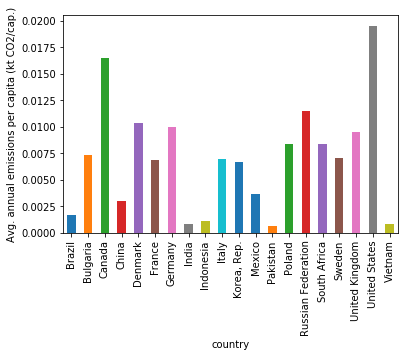

In [55]:
ax = both.groupby('country').co2.mean().plot(kind='bar')
ax.set_ylabel('Avg. annual emissions per capita (kt CO2/cap.)'); 

How about the annualized growth rates? Recall that these are calculated using the formula 
\\[ \text{annual growth} = \left( \frac{y_{t_1}}{y_{t_0}} \right) ^ {\frac{1}{t_1 - t_0}} \\]

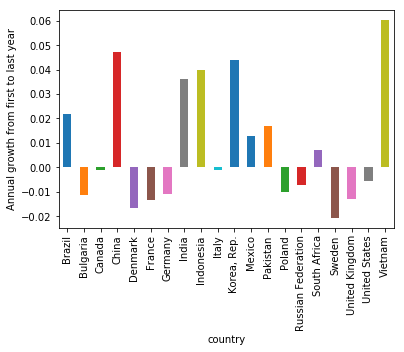

In [56]:
def annual_growth(x): 
    x_last    = x.values[-1]
    x_first   = x.values[0]
    num_years = len(x)
    
    growth_annualized = (x_last/x_first)**(1/num_years) - 1.0
    return growth_annualized

ax = both.groupby('country')['co2'].agg(annual_growth).plot(kind='bar')
ax.set_ylabel('Annual growth from first to last year'); 

Now we see that many developing countries (China, Vietnam, Korea, India) stand out with massive increases in CO2 emissions. For most of the developed countries, we see modest decreases in emissions. 

Next, we will zoom in on the developments over time for each country. We start with one big graph that is impossible to read. 

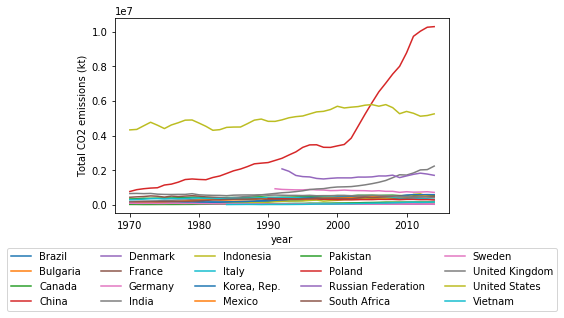

In [57]:
fig = plt.figure()
ax = plt.subplot(111)
both.set_index('year').groupby('country')['co2_tot'].plot(kind='line', legend=True, ax=ax);
ax.set_ylabel('Total CO2 emissions (kt)')
box = ax.get_position() # find plot coordinates 
ax.set_position([box.x0, box.y0 + box.height * 0.1,box.width, box.height * 0.9]) # shrink height by 10% at bottom 
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),ncol=5); # Put a legend below current axis

That graph is extremely hard to read so let's use a `FacetGrid` from the plotting package `seaborn`: 

In [58]:
import seaborn as sns # a package full of nice things! Google it... 

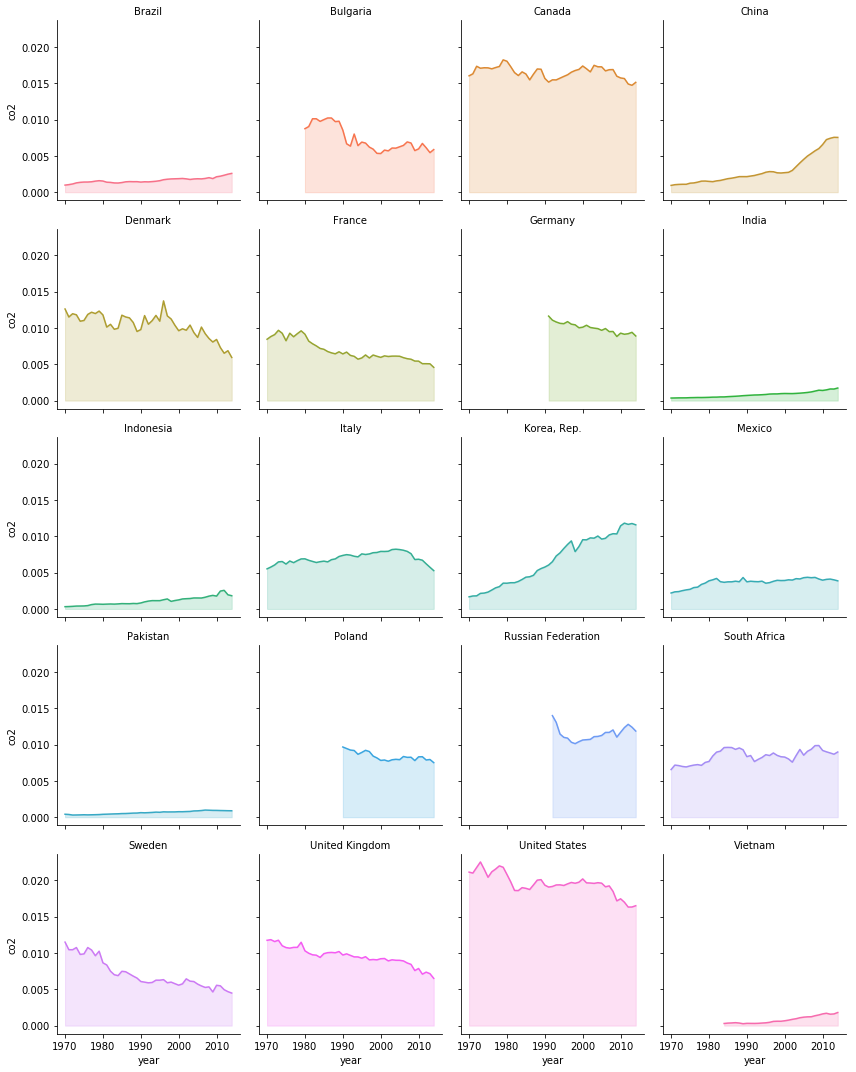

In [59]:
by_var = 'country'
y_var  = 'co2'

g = sns.FacetGrid(both, col=by_var, hue=by_var, col_wrap=4)
g = g.map(plt.plot, 'year', y_var) # draw the upper line 
g = g.map(plt.fill_between, 'year', y_var, alpha=0.2).set_titles("{col_name} "+by_var) # draw the underlying area 
g = g.set_titles("{col_name}") # # Control the title of each facet

**Tentative conclusion:** We have seen strong increases in emissions in many developing countries and minor falls in emissions in some of the more developed countries. Initially, this might indicate that there is no strong relationship between CO2 and GDP. However

## GDP and CO2

The above is across countries, what is the relationship between avg. GDP and avg. emissions. What about within a country? How do changes in GDP correlate with changes in CO2? 

### Across-country comparisons

First, we analyze the problem by focusing on comparisons that go across countries. To do this, we must collapse the data within a country, e.g. by taking the average emissions over time. 

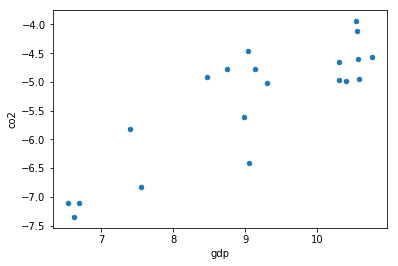

In [60]:
(both.groupby('country').mean() 
      .apply(np.log) 
      .plot(kind='scatter', x='gdp', y='co2')); 

This graph seems to indicate that there is indeed a relationship between GDP and CO2: countries with a higher GDP per capita tend to have higher CO2 emissions per capita. It even looks like one log point in GDP translates into nearly a full log point in CO2. 

### Within-country comparisons

It is possible that the across-country comparison above is invalid. There might be an omitted variable. It might be that large economies are located where it is cold and thus have to spend much effort to heat houses, which burns CO2. It might be that if we take any *given* country, that *all else equal* increasing GDP will lead to lower CO2. Maybe because the country can now afford to invest in green tech. 

To explore whether that is the case, we can focus on *within-country variation* rather than *across country variation*. One example of what is meant by this is that we can focus on the relationship between observed changes in GDP and changes in CO2.  

#### Average differences 

First, we compute for each country (using a `groupby`), the average one-year growth rate for that country, using the function `pct_change()`. 

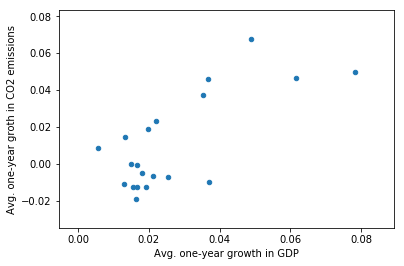

In [61]:
ax = both.groupby('country').agg(lambda x : x.pct_change().mean()).plot(kind='scatter',x='gdp',y='co2')
ax.set_xlabel('Avg. one-year growth in GDP');
ax.set_ylabel('Avg. one-year groth in CO2 emissions');

Just as a test, let us make sure that the *average log differences* give approximately the same picture: 

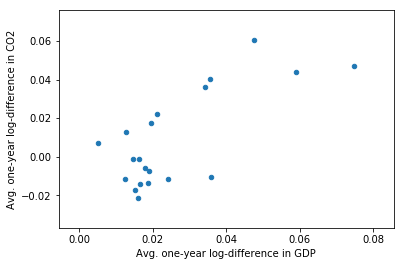

In [62]:
ax = both.groupby('country').agg(lambda x: (np.log(x)).diff().mean()).plot(kind='scatter',x='gdp',y='co2')
ax.set_xlabel('Avg. one-year log-difference in GDP');
ax.set_ylabel('Avg. one-year log-difference in CO2');

**Partial conclusion:** From these graphs, we draw the same conclusion: there is a positive relationship between changes in GDP and changes in CO2. *However*, we do note that for sufficiently low changes in GDP (less than 2%), CO2 emissions are actually *falling*. If we take that at face value, this appears to indicate that it is possible to have positive growth while still reducing emissions. But the relationship is monotonic (based on what our data tells us).  

#### Pooled differences

Instead of taking the average (over time) change in GDP and in CO2  within each country, we can also just plot all the annual differences. 

In [63]:
logdiffs = both.set_index('country').groupby(level=0).transform(lambda x : (np.log(x)).diff(1) ).reset_index()

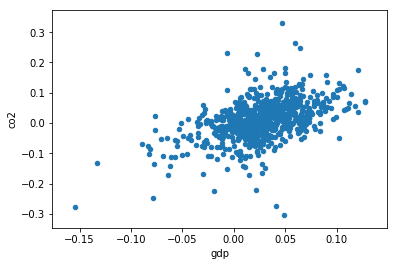

In [64]:
logdiffs.plot(kind='scatter', x='gdp', y='co2'); 

Again we see there appears to be a positive relationship. However, we may be worried that it is driven by *outliers*. That is, we would like to think about how much data we have where. For this, we can use the `seaborn` plot, `jointplot`, which simultaneously indicates (with color intensity and marginal histograms) what the data density looks like. We would lik to mainly draw our conclusions based on where we have a fair amount of data. 

/Users/mrz577/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


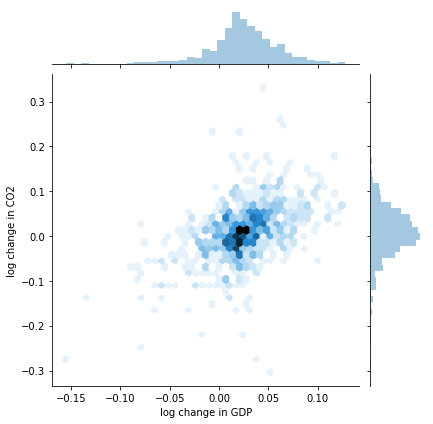

In [65]:
h = sns.jointplot(x=logdiffs.gdp, y=logdiffs.co2, kind='hex')
h.set_axis_labels('log change in GDP', 'log change in CO2');

### Regression model 

In many settings, a linear regression can be a great way of summarizing the dataset. 

We will estimate the following models
\begin{align}
  (0): \log \text{CO}_2 &= \beta_0 + \beta_1 \log \text{GDP}  + \text{error} \\
  (1): \log \text{CO}_2 &= \beta_0 + \beta_1 \log \text{GDP} + \text{time trend} + \text{error} \\
  (2): \log \text{CO}_2 &= \beta_0 + \beta_1 \log \text{GDP} + \text{time trend} + \text{country fixed effects} + \text{error} \\
 (3): \Delta \log \text{CO}_2 &= \tilde{\beta}_0 + \beta_1 \Delta \log \text{GDP} + \text{error} \\ 
  (4): \Delta \log \text{CO}_2 &= \tilde{\beta}_0 + \beta_1 \Delta \log \text{GDP} + \text{country fixed effects} + \text{error}. 
\end{align}

In model (0), we are simply comparing all observations. If there is a general tendency over time that is unrelated to GDP but that has affected emissions, then we are not accounting for it. That is done by (1). However, there might still be omitted variables specific to each country that affect the emissions and affect the GDP and thus cause endogeneity (e.g. temperature / distance from equator). Model (2) takes this into account. 

The models (3) and (4) are first-difference specifications. In principle, model (3) should be equivalent to (2) if it is correctly specified. In practice, the two can differ due to a number of misspecifications. For example, if the country fixed effects are slowly changing over time, perhaps due to slow, gradual changes in temperature (and thus in heating needs), or preferences or productivity. In that case, focusing on short-run movements in first-differences may be more acurate. On the other hand, if there are a lot of short-run fluctuations, then fixed effects are perhaps closer to the truth. In practice, these are questions that depend on the specific deviations. We will simply estimate both and check whether they are close. 

In [66]:
res0 = sm.ols(formula='np.log(co2)~1+np.log(gdp)',                    data=both).fit()
res1 = sm.ols(formula='np.log(co2)~1+np.log(gdp)+C(year)',            data=both).fit()
res2 = sm.ols(formula='np.log(co2)~1+np.log(gdp)+C(year)+C(country)', data=both).fit()
res3 = sm.ols(formula='co2~1+gdp',                                    data=logdiffs).fit() # in this dataframe, variables are already logged
res4 = sm.ols(formula='co2~1+gdp+C(country)',                         data=logdiffs).fit() # in this dataframe, variables are already logged

print(f'Baseline:        {res0.params["np.log(gdp)"] : 8.4f}')
print(f'Year FE:         {res1.params["np.log(gdp)"] : 8.4f}')
print(f'Year+Country FE: {res2.params["np.log(gdp)"] : 8.4f}')
print(f'FD:              {res3.params["gdp"]         : 8.4f}')
print(f'FD + country FE: {res4.params["gdp"]         : 8.4f}')

Baseline:          0.6231
Year FE:           0.6257
Year+Country FE:   0.8485
FD:                0.9026
FD + country FE:   0.8584


We could easily extend the model with e.g. country fixed effects by writing `co2~gdp+C(country)`. 

**Plotting** the estimates in a cool graph: 

In [67]:
res = pd.DataFrame(data = [
        ['Baseline',         res0.params["np.log(gdp)"], res1.bse["np.log(gdp)"]], 
        ['Year FE',        res1.params["np.log(gdp)"], res1.bse["np.log(gdp)"]], 
        ['Year+country FE', res2.params["np.log(gdp)"], res2.bse["np.log(gdp)"]], 
        ['FD',              res3.params["gdp"],         res3.bse["gdp"]],
        ['FD+country FE',   res4.params["gdp"],         res4.bse["gdp"]],
    ], columns=['Model','estimate','se'])

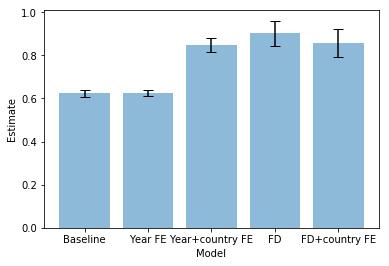

In [68]:
fig, ax = plt.subplots()
x_pos = range(res.shape[0])
ax.bar(x_pos, res.estimate, yerr=res.se,  alpha=0.5, ecolor='black', capsize=5);
ax.set_xticks(x_pos);
ax.set_xticklabels(res.Model);
ax.set_ylabel('Estimate');
ax.set_xlabel('Model');

### Conclusion

**Overall:** Unfortunately, our investigations document a clear correlation between GDP and CO2 Emissions. We estimate an elasticity between 0.63 and 0.90, although we put more confidence in the three models that account for country fixed effects, where the estimate ranges between 0.85 and 0.90. This is a quite high elasticity, implying that economic growth almost moves one-for-one with CO2 emissions. 